# Trajectory planning with obstacle avoidance and nonlinear constraints

## Problem description

We want to generate a trajectory from a given starting point which meets following criteria:
 * the planar motion of the agent is driven by horizontal and vertical speeds $v_x$ and $v_y$, respectively,
 * the overal speed, i.e., $v = \sqrt{v_x^2+v_y^2}$ is bounded,
 * at the end of the prediction horizon the agent's position must be as close as possible to the desired location.


## Agent setup

We model agent's dynamics as two decoupled integrators, i.e.,
\begin{align}
   \dot{p}_x & = v_x\\
   \dot{p}_y & = v_y
\end{align}

where $p_x$, $p_y$ are the positions in the $x$- and $y$-axis, respectively. The control inputs are the horizontal ($v_x$) and vertical speeds ($v_y$). Since optiplan only supports discrete-time formulations, we will discretize the dynamics using simple forward Euler rule with a given sampling time, i.e.:
\begin{align}
   p_x(k+1) & = p_x(k) + T_{\text{s}} v_x(k) \\
   p_y(k+1) & = p_y(k) + T_{\text{s}} v_y(k)
\end{align}

This will be subsequently translated to $x(k+1) = A x(k) + B u(k)$, with $x(k) = [p_x(k), p_y(k)]^T$ and $u(k) = [v_x(k), v_y(k)]^T$.


The prediction horizon must be long enough for the agent to be able to reach the final location despite constaints on the overal speed.

The prediction horizon must be long enough for the agent to be able to reach the final location despite constaints on the overal speed.

In [1]:
N = 30;

Now we create the planner:

In [2]:
nx = 2; nu = 2; ny = 2;
agent = optiplan.LinearAgent('Nx', 2, 'Nu', 2, 'Ny', 2, 'PredictionHorizon', N);
agent.Size.Value = [0.5; 0.5]; % width and height of the agent

The agent's linear dynamics is time-invariant:

In [3]:
Ts = 1; % sampling time
A = eye(2); B = Ts*eye(2);
agent.A.Value = A;
agent.B.Value = B;
agent.f.Value = zeros(nx, 1);
agent.C.Value = eye(ny); % in optiplan, the outputs must always be the positions
agent.D.Value = zeros(ny, nu);
agent.g.Value = zeros(ny, 1);

No constraints on positions, and speeds in individual axes (only on the overall speed, that one will be added later):

In [4]:
agent.X.Min = -Inf(nx, 1);
agent.X.Max = Inf(nx, 1);
agent.U.Min = -Inf(nu, 1);
agent.U.Max = Inf(nu, 1);
agent.Y.Min = -Inf(ny, 1);
agent.Y.Max = Inf(ny, 1);

No penalties/references on states/inputs

In [5]:
agent.X.Penalty = zeros(nx);
agent.X.Reference = zeros(nx, 1);
agent.U.Penalty = zeros(nu);
agent.U.Reference = zeros(nu, 1);

The output (position) reference can be time-varying, as well as the position penalty:

In [6]:
agent.Y.Penalty = 'parameter';
agent.Y.Reference = 'parameter';

## Nonlinear constraints

But here's the trick: we want to limit the overal speed, given by $v = \sqrt{v_x^2+v_y^2}$ from above by $v_{\text{max}}$. To make the problem a bit simpler to solve, we square both sides of the inequality to get $v_x^2 + v_y^2 \le v_{\text{max}}^2$. But it's still a nonlinear constraint (albeit convex).

Nonlinear constraints are added via a custom function handle. It must point to a function which takes 4 inputs:
 * the state predictions $X = [x_0, \ldots, x_{N}]$,
 * the input predictions $U = [u_0, \ldots, u_{N-1}]$,
 * the output predictions $Y = [y_0, \ldots, y_{N-1}]$,
 * the agent object

Additionaly, we want the agent to be stationary at the end of the optimized path, i.e., $u_{N-1}=0$.

Both the position constaints as well as the bound on absolute speed will be added via a function:

In [7]:
vmax = 3;
agent.ConstraintsFun = @(X, U, Y, agent) myConstraints(U, agent, vmax);

Here, `myConstraints` is a custom function like this one:

## Custom optimization objective

In addition, we want to minimize the length of the path. Since we do point-wise optimization, this can be done by minimizing $\sum_{k=0}^{N-1} (y_{k+1} - y_{k})^T (y_{k+1} - y_{k})$, where the terms in the sum are squared distances between two consecutive points on the path.

Custom objectives like this one can be added via the `ObjectiveFun` property of the agent. It also has to be a function handle with 4 inputs:

In [8]:
agent.ObjectiveFun = @(X, U, Y, agent) myObjective(Y, agent);

Here, `myObjective` is again a custom function:

## Obstacles

We also consider three stationary obstacles:

In [9]:
nObstacles = 3;
obstacles = optiplan.Obstacle(agent, nObstacles);
obstacles(1).Position.Value = [10; -4]; % center of the obstacle
obstacles(1).Size.Value = [8; 4]; % width and height
obstacles(1).Visible.Value = 1; % it's visible to the agent
obstacles(2).Position.Value = [-0.5; -8];
obstacles(2).Size.Value = [5; 12];
obstacles(2).Visible.Value = 1;
obstacles(3).Position.Value = [0; -0.6];
obstacles(3).Size.Value = [8; 1];
obstacles(3).Visible.Value = 1;

## The planner

Now we create a planner which will optimize the path. Due to the nonlinear speed constraints, the problem will be solved as a mixed-integer quadratically constrained quadratic program (MI-QCQP). Fortunately for us, the nonlinear constraints are at least convex.

We want the agent to keep at least one multiple of its size as a safety separation gap between itself and the obstacles. To do that, we set the `MinSeparation` property when calling the `Planner` constructor:

## The optimization

Starting and desrired finishing points:

In [10]:
start = [10; -10];
destination = [-5; -2];

Assign values to planner's parameters. Here, we only heavily penalize the deviation of the final predicted position from the desired point and don't care about the intermediate points:

In [11]:
planner.Parameters.Agent.Y.Penalty = [repmat(zeros(ny), 1, N-1), 1e4*eye(ny)];
planner.Parameters.Agent.Y.Reference = destination;

Run the optimization:

Any issues?

If the problem is feasible, the optimal path is available in `results.Y`. Each column of that matrix represents one waypoint of the path. Just keep in mind that the optimization is performed point-wise, i.e., only the waypoints are guaranteed to avoid obstacles.

## Visualization

/Users/filip/Documents/Mercurial/bitbucket/optiplan-copy/src/examples


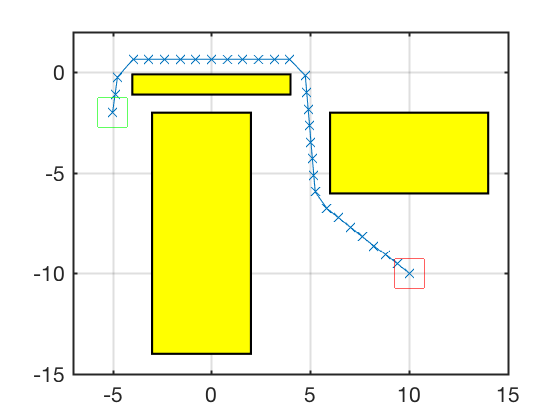

optpath =

  Columns 1 through 7

   10.0000    9.4062    8.8125    8.2187    7.6250    7.0312    6.4375
  -10.0000   -9.5357   -9.0714   -8.6071   -8.1429   -7.6786   -7.2143

  Columns 8 through 14

    5.8437    5.2500    5.1786    5.1071    5.0357    4.9643    4.8929
   -6.7500   -5.9278   -5.1056   -4.2833   -3.4611   -2.6389   -1.8167

  Columns 15 through 21

    4.8214    4.7500    3.9583    3.1667    2.3750    1.5833    0.7917
   -0.9944   -0.1722    0.6500    0.6500    0.6500    0.6500    0.6500

  Columns 22 through 28

         0   -0.7917   -1.5833   -2.3750   -3.1667   -3.9583   -4.7500
    0.6500    0.6500    0.6500    0.6500    0.6500    0.6500   -0.2333

  Columns 29 through 30

   -4.8750   -5.0000
   -1.1166   -1.9999


In [12]:
%cd ~/Documents/Mercurial/bitbucket/optiplan-copy/src/examples/
%clear classes
%format short
optpath = opt_demo8
axis([-7 15 -15 2])

## Notes

 * prediction horizon must be fixed
 * starting location can be arbitrary
 * final location is fixed (but can be made parametric, contact me)
 * upper speed bound is fixed (but can be made parametric)
 * minimal separation gap is fixed